In [2]:
import pickle
import pandas as pd
from CITEsort_rna.BTreeTraversal import BTreeTraversal
from CITEsort_rna.Visualize import plot_keymarker,visualize_tree
import matplotlib
#import numpy as np
from matplotlib import pyplot as plt
import scanpy as sc
from metadimm import MetaDIMM

## load data and tree 

In [3]:
adata = sc.read_h5ad('../CITE-sortV2-main/datasets/SeuratV4/rna_with_label.h5ad')
# ct_list = ['CD4 Naive','CD8 Naive','CD14 Mono']
# adata = adata[adata.obs['label_l2'].isin(ct_list),:]
# adata = sc.read_h5ad('./output/rna/CD4_CD8_Naive_CD14_Mono/adata_pp.h5ad')
f = open('./output/rna/main_p8_/tree.pickle','rb')
# f = open('CITEsort_out/SeuratV3_main_ct_smooth2/tree.pickle','rb')
tree = pickle.load(f)
f.close()

In [4]:
traversal = BTreeTraversal(tree)
md = MetaDIMM()
adata = adata[tree.indices,:]
adata = md.filter(adata)
adata = md.preprocess(adata, normalize=True, log1p=True, hvg=True, scale=True)

/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


-----------------------------------
Function 'filter' executed in 0.79s
-----------------------------------
---------------------------------------
Function 'preprocess' executed in 2.12s
---------------------------------------


## plot compact tree or complete tree
#### The paramter '--compact' of runing runCITEsort.py will set the tree in compact format. If complete format is needed, plot tree again as below. The filename should no longer be 'tree', or the original tree.pdf will be overwritten.

In [4]:
# visualize_tree(tree,data,outpath='./CITEsort_out',filename='tree_complete',compact=False)

## visualize all markers in a certain node
#### the node ID is just the number before the node name in tree.pdf

/home/xinzhu/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/xinzhu/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


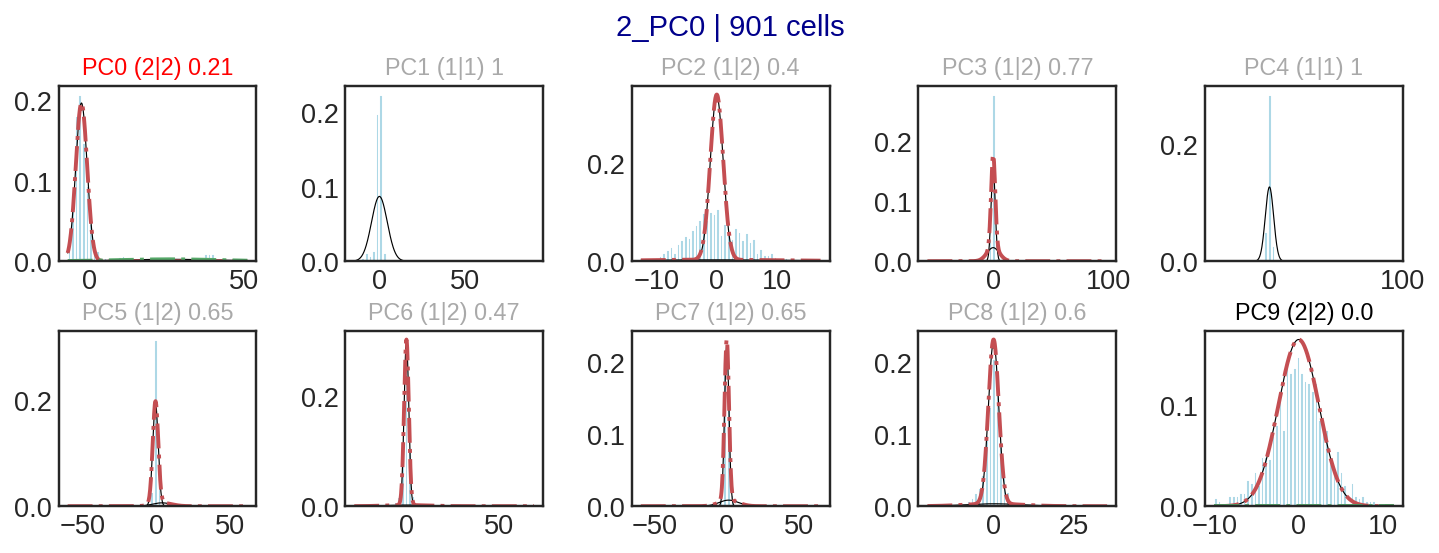

In [6]:
node_ID = 2
traversal.plot_node(adata,node_ID,viz_dim=1,savefig=False)

In [6]:
node = traversal.get_node(5)
node.val_cnt[node.val_cnt>100]

TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [ ]:
import diptest
diptest.dipstat(data.loc[node.indices,'CD8a'])
# len(data.loc[node.indices,'CD158'])

0.008844678946540079

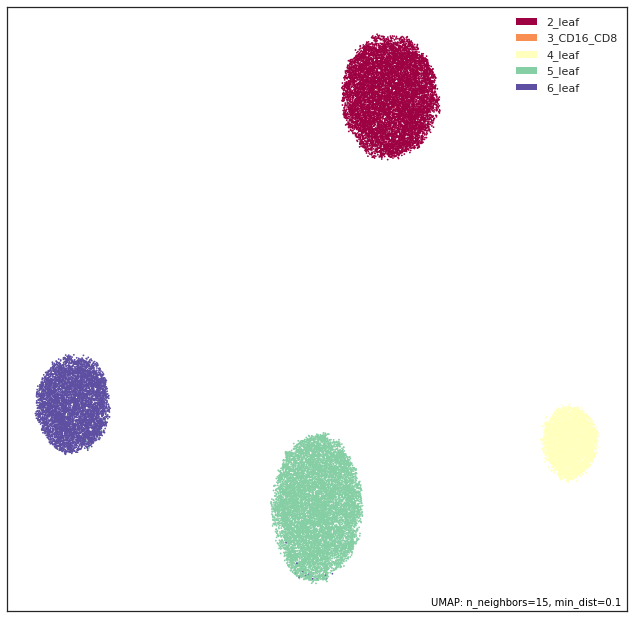

In [ ]:
traversal.plot_node_umap(data, nodeID=6)

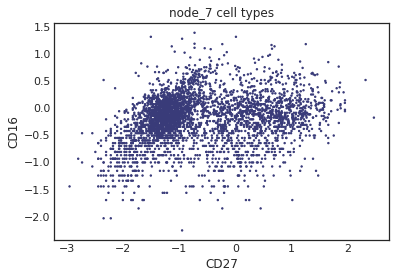

In [ ]:
traversal.plot_node_2dim_new(data, 7, 'CD27', 'CD16')
# traversal.plot_node_2dim_new(data, 20, 'CD8a', 'CD4')
# traversal.plot_node_2dim_new(data, 2, 'CD4-1', 'CD19')

In [ ]:
score_ll = traversal.get_ll(12)
print('likelyhood gain:')
for key,value in score_ll.items():
    print(key,round(value,3))

likelyhood gain:
('CD161',) 1.242
('CD56',) 0.331


## visualize the key marker in a certain node
#### the node ID is just the number before the node name in tree.pdf

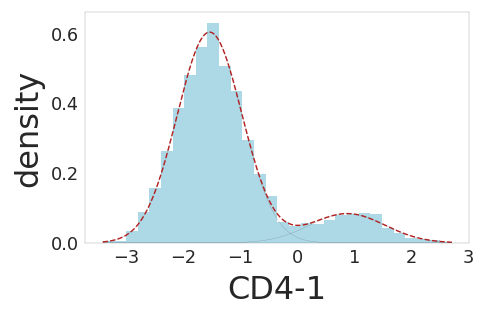

In [ ]:
plot_keymarker(data,traversal,node_ID=2,dpi=128)

In [ ]:
from scipy.stats import multivariate_normal, norm
import numpy as np

def assign_GMM(sample, mean_list, cov_list, weight, if_log=False, marker_list=None):
    # print(cov_list)
    index = sample.index
    # sample = np.array(sample)
    weight = np.array(weight)
    if if_log:
        type_num = np.log(weight/sum(weight))
    else:
        type_num = weight/sum(weight)
    
    p_prior = np.zeros(shape=(len(sample),len(weight)))
    for i in range(len(weight)):
        if if_log:
            # print(i)
            p_prior[:,i] = multivariate_normal.logpdf(np.array(sample.loc[:,marker_list]), mean=np.array(mean_list[i][marker_list]), cov=np.array(cov_list[i].loc[marker_list,marker_list]),allow_singular=True)
            p_prior[:,i] = p_prior[:,i] + type_num[i]
            
        else:
            
            # print([cov_list[i][j,j] for j in range(len(cov_list[i]))])
            # print(sample.loc[:,marker_list[i]])
            # print(mean_list[i])
            # print(cov_list[i])
            p_prior[:,i] = multivariate_normal.pdf(np.array(sample.loc[:,marker_list[i]]), mean=np.array(mean_list[i]), cov=np.array(cov_list[i]))   
            p_prior[:,i] = p_prior[:,i] * type_num[i]
    # p_prior = -p_prior 
    
    p_post = p_prior / (p_prior.sum(axis=1)[:,np.newaxis] )
    pred_label = np.argmin(p_post,axis=1)
    # print(p_prior[:10,:])
    # print(pred_label[:10])
    pred_label = pd.Series(data=pred_label,index=index)
    return pred_label

In [ ]:
leaf_list = traversal.nodelist.copy()
leaf_list.pop(0)
leaf_list.pop(0)
leaf_list.pop(1)

In [ ]:
node = traversal.get_node(3)
mean_list = [node.mean for node in leaf_list] 
cov_list = [node.cov for node in leaf_list]
w_list = [node.weight for node in leaf_list]
simulator = pd.read_csv('../simulator/ADT_simulator_9_10.csv', sep=',', index_col=0, header=0)
raw_label = assign_GMM(simulator, mean_list, cov_list, w_list, if_log=True,marker_list=['CD4-1','CD19','CD16','CD8'])
add_label = assign_GMM(simulator, mean_list, cov_list, w_list, if_log=True,marker_list=['CD4-1','CD19','CD16','CD8','CD3-1'])
#### 尝试用所有cutof<0.5的feature来assign，相当于是一个高维的gate

<AxesSubplot:>

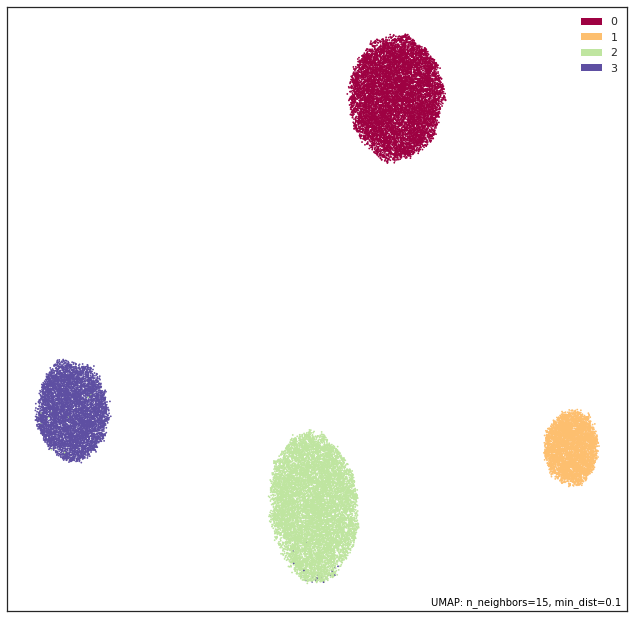

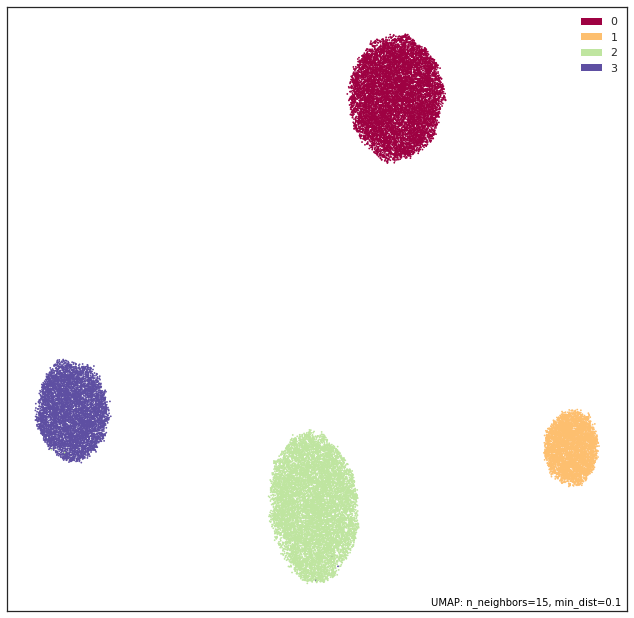

In [ ]:
import umap
import umap.plot
import matplotlib.pyplot as plt

mapper = umap.UMAP().fit(simulator)
umap.plot.points(mapper, labels=raw_label)
umap.plot.points(mapper, labels=add_label)

In [ ]:
raw_label.iloc[20675:].value_counts()
# add_label.iloc[20675:].value_counts()

2    9851
3      21
dtype: int64

In [ ]:
# add_label.index = simulator.index
simulator[raw_label==3].to_csv('../simulator/ADT_simulator_9_11.csv')

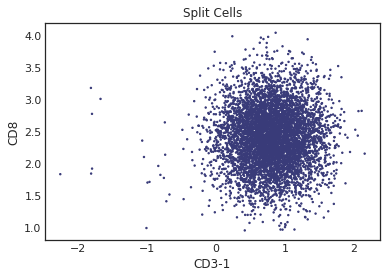

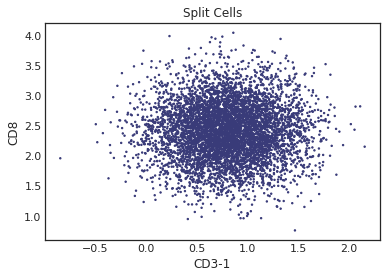

In [ ]:
from CITEsort.Visualize import visualize_2dim

visualize_2dim(simulator[raw_label==3]['CD3-1'],simulator[raw_label==3]['CD8'],raw_label[raw_label==3])
visualize_2dim(simulator[add_label==3]['CD3-1'],simulator[add_label==3]['CD8'],add_label[add_label==3])

In [ ]:
keys = []
for i in range(28):
    node = traversal.get_node(i)
    if list(node.key) != 'leaf':
        print(node.key)

('CD26-1',)
('IgD',)
('CD26-1',)
('leaf',)
('CD72',)
('CD4-1',)
('CD4-1',)
('CD27', 'CD8a')
('CD8a',)
('leaf',)
('CD244',)
('CD4-1',)
('leaf',)
('CD27',)
('leaf',)
('leaf',)
('leaf',)
('leaf',)
('CD244',)
('leaf',)
('leaf',)
('CD158', 'CD21')
('CD3-1',)
('leaf',)
('leaf',)
('leaf',)
('leaf',)
('leaf',)


In [ ]:
'IgD',
'CD26-1',
'CD72',
'CD4-1',
'CD27', 'CD8a
'CD8a',
'CD244',
'CD4-1',
'CD27',
'CD244',
'CD158', 'CD21',
'CD3-1'

TypeError: unhashable type: 'list'